In [1]:
cd ../../task_01/pipelines

/Users/mathieuchevalley/Documents/Study/ETHZ/Fall Semester 2020/Data Science lab/data_sc_lab/task_01/pipelines


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipynb.fs.full.tool_functions import *
from yellowbrick.regressor import AlphaSelection

In [3]:
df_spectro_cluster = pd.read_csv("../../../data/EEG/RestingEEG_Spectro_Cluster.csv")
df_beha = pd.read_csv('../../../data/Behavioral/AllData.csv')

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (66,68,80,81,82,83,84,95,96,97,98,99,110,111,112,113,114,125,126,127,128,129,140,141,142,144,155,156,157,159,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031,1032,1033,1034,1035,1036,1037,1038,1039,1040,1041,1042,1043,1044,1045,1046,1047,1048,1049,1050,1051,1052,1053,1054,1055,1056,1057,1058,1059,1060,1061,1062,1063,1064,1065,1066,1067,1068,1069,1070,1071,1072,1073,1074,1075,1076,1077,1078,1079,1080,1081,1082,1083,1084,1085,1086,1087,1088,1089,1090,1091,1092,1093,1094,1095,1096,1097,1098,1099,1100,1101,1102,1103

In [4]:
s_in = df_beha[['SWAN_IN_Avg' , 'Age', 'Patient_ID']]

In [5]:
s = df_beha[['SWAN_IN_Avg' , 'SWAN_HY_Avg', 'Age', 'Patient_ID']]
s = s[~s_in['SWAN_IN_Avg'].isnull()]

In [166]:
df_spectro_cluster.rename(columns={'id': 'Patient_ID'}, inplace=True)
df_label_spectro_cluster = pd.merge(s, df_spectro_cluster, on='Patient_ID')

df_label_spectro_cluster = fill_with_median(df_label_spectro_cluster)

In [167]:
less_18 = df_label_spectro_cluster['Age'] <= 18.0
df_label_spectro_cluster = df_label_spectro_cluster[less_18]

In [194]:
from sklearn.model_selection import train_test_split

x_train , x_test, y_train , y_test = \
train_test_split(df_label_spectro_cluster.drop(['Age', 'SWAN_IN_Avg' , 'SWAN_HY_Avg', 'Patient_ID'], 
                                               axis=1
                                              ).to_numpy(), 
                 df_label_spectro_cluster[[ 'Age', 'SWAN_IN_Avg', 'SWAN_HY_Avg']].to_numpy(), test_size=0.2, random_state = 0)
mean = x_train.mean(axis=0)
x_train -= mean
x_test -= mean

In [45]:
import keras
from keras import layers
encoding_dim = 20

# This is our input image
input_img = keras.Input(shape=(len(x_train[0]),))
# "encoded" is the encoded representation of the input
encoded1 = layers.Dense(30, activation='relu')(input_img)
encoded = layers.Dense(encoding_dim)(encoded1)
# "decoded" is the lossy reconstruction of the input
decoded1 = layers.Dense(20, activation='relu')(encoded)
decoded = layers.Dense(len(x_train[0]))(decoded1)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

encoder = keras.Model(input_img, encoded)

encoded_input = keras.Input(shape=(encoding_dim,))

decoder_layer = autoencoder.layers[-1]

decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

In [46]:
autoencoder.compile(optimizer='adam', loss='mse')


In [47]:
autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 990 samples, validate on 248 samples
Epoch 1/100
990/990 [==============================] - 0s 168us/step - loss: 20.1792 - val_loss: 15.0386
Epoch 2/100
990/990 [==============================] - 0s 49us/step - loss: 9.1748 - val_loss: 6.9713
Epoch 3/100
990/990 [==============================] - 0s 43us/step - loss: 5.4793 - val_loss: 5.7810
Epoch 4/100
990/990 [==============================] - 0s 35us/step - loss: 4.4873 - val_loss: 4.3671
Epoch 5/100
990/990 [==============================] - 0s 35us/step - loss: 3.1832 - val_loss: 3.1826
Epoch 6/100
990/990 [==============================] - 0s 35us/step - loss: 2.4040 - val_loss: 2.5749
Epoch 7/100
990/990 [==============================] - 0s 35us/step - loss: 1.9694 - val_loss: 2.1832
Epoch 8/100
990/990 [==============================] - 0s 35us/step - loss: 1.6906 - val_loss: 1.9577
Epoch 9/100
990/990 [==============================] - 0s 35us/step - loss: 1.5343 - val_loss: 1.8366
Epoch 10/100
990/990 [===========

In [34]:
encoded_imgs = encoder.predict(x_train)

In [35]:
encoded_imgs

array([[ 1.5333463e+00,  7.8951620e-02, -5.1571169e+00, ...,
        -1.5016685e+01,  1.0097332e+01, -4.3006411e-01],
       [ 3.8746827e+00, -3.3670216e+00, -3.5001080e+00, ...,
        -1.2628110e+01,  1.4226035e+01,  6.9952691e-01],
       [ 2.7147850e+01,  2.3087766e+00, -1.8987402e+01, ...,
        -1.0391088e+02,  7.1357063e+01, -6.0240658e+01],
       ...,
       [ 2.5293677e+00, -1.3727685e+00, -6.6768837e+00, ...,
        -1.9616850e+01,  4.9317651e+00, -1.0171193e+00],
       [ 4.5820646e+00,  2.4991463e+01, -7.4803579e-01, ...,
        -6.7125602e+00,  1.4461714e+01, -1.8677593e+01],
       [ 2.9988691e-01,  3.6117531e+01, -6.7968311e+00, ...,
        -9.9399004e+00,  2.6696980e+01, -3.7839966e+01]], dtype=float32)

In [36]:
from yellowbrick.contrib import ScatterVisualizer

ScatterVisualizer(alpha=1.0,
                  ax=<matplotlib.axes._subplots.AxesSubplot object at 0x14a260fd0>,
                  classes=None, color=None, colormap=None, features=['x', 'y'],
                  markers=<itertools.cycle object at 0x14a6cf280>, x='x',
                  y='y')

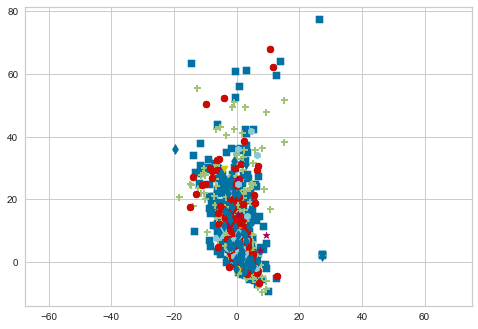

In [37]:
visualizer = ScatterVisualizer(x="x", y="y")
visualizer.fit(encoded_imgs[:, :2], y_train[:, 1].astype(int))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

TSNEVisualizer(alpha=0.7,
               ax=<matplotlib.axes._subplots.AxesSubplot object at 0x14a20c710>,
               classes=None, colormap=None, colors=None, decompose=None,
               decompose_by=None, labels=None, random_state=None)

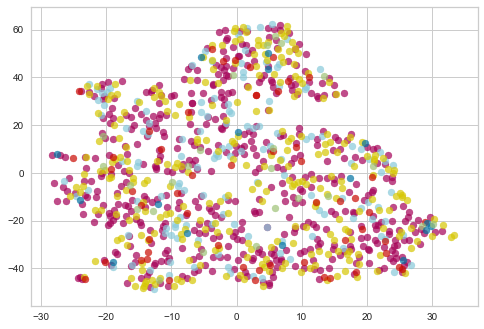

In [38]:
from yellowbrick.text import TSNEVisualizer
tsne = TSNEVisualizer(decompose=None)
tsne.fit(encoded_imgs, y_train[:, 1].astype(int))

In [42]:
from sklearn import svm
svr= svm.SVR(kernel = 'rbf', C=10)
#parameters = {'kernel' : ( 'rbf' , 'poly', 'linear', 'sigmoid' ), 'C':[0.1, 1,10,100], 'gamma':['auto', 10e-2, 10e-1, 1, 2]}
#clf = GridSearchCV(svr, parameters ,cv =5, scoring='neg_mean_squared_error')
svr.fit(encoded_imgs , y_train[:,0])


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [43]:
import sklearn
sklearn.metrics.mean_squared_error(y_test[:,0] , svr.predict(encoder.predict(x_test)))

9.906637155124354

In [ ]:
svr_final = svm.SVR(kernel = best_param['kernel'] , C = best_param['C'])
svr_final.fit(x_train , y_train)
test_mse_svm = sklearn.metrics.mean_squared_error(y_test , svr_final.predict(x_test))

In [195]:
import keras
from keras import layers

latent_dim = 15

inputs = keras.Input(shape=(len(x_train[0]),))
h = layers.Dense(20, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

In [196]:
from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [197]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(20, activation='relu')(latent_inputs)
outputs = layers.Dense(len(x_train[0]))(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [198]:
reconstruction_loss = keras.losses.mean_squared_error(inputs, outputs)
reconstruction_loss *= len(x_train[0])
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [199]:
vae.summary()

Model: "vae_mlp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 300)]        0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 15), (None,  6650        input_15[0][0]                   
__________________________________________________________________________________________________
decoder (Model)                 (None, 300)          6620        encoder[1][2]                    
__________________________________________________________________________________________________
dense_72 (Dense)                (None, 20)           6020        input_15[0][0]                   
____________________________________________________________________________________________

In [212]:
x_train2 = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test2 = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
vae.fit(x_train2, x_train2,
        epochs=100,
        batch_size=32,
        shuffle=True,
        validation_data=(x_test2, x_test2))

Epoch 1/100
31/31 [==============================] - 0s 4ms/step - loss: 382.7013 - val_loss: 478.2456
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 383.1862 - val_loss: 476.9475
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 381.8177 - val_loss: 476.9280
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 381.9612 - val_loss: 475.2827
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 381.0777 - val_loss: 474.2867
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 382.0010 - val_loss: 477.0863
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 380.7816 - val_loss: 474.7978
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 379.1333 - val_loss: 472.1496
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 376.6036 - val_loss: 472.2685
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss:

Epoch 80/100
31/31 [==============================] - 0s 2ms/step - loss: 339.3154 - val_loss: 424.1931
Epoch 81/100
31/31 [==============================] - 0s 2ms/step - loss: 339.5754 - val_loss: 424.6852
Epoch 82/100
31/31 [==============================] - 0s 2ms/step - loss: 338.7651 - val_loss: 423.0519
Epoch 83/100
31/31 [==============================] - 0s 2ms/step - loss: 339.2383 - val_loss: 423.1735
Epoch 84/100
31/31 [==============================] - 0s 2ms/step - loss: 336.0513 - val_loss: 422.1165
Epoch 85/100
31/31 [==============================] - 0s 2ms/step - loss: 335.9863 - val_loss: 420.6820
Epoch 86/100
31/31 [==============================] - 0s 2ms/step - loss: 336.1928 - val_loss: 421.1600
Epoch 87/100
31/31 [==============================] - 0s 2ms/step - loss: 334.9247 - val_loss: 424.0427
Epoch 88/100
31/31 [==============================] - 0s 2ms/step - loss: 335.0549 - val_loss: 421.0338
Epoch 89/100
31/31 [==============================] - 0s 2ms/ste

In [213]:
import sklearn
sklearn.metrics.mean_squared_error(x_test, vae.predict(x_test))

1.3185870816865024

In [214]:
encoded_imgs = encoder.predict(x_train)[2]

In [215]:
encoded_imgs

array([[ 2.9456346 , -1.0718926 ,  1.3948984 , ..., -0.02844605,
         0.8596197 , -1.4304868 ],
       [ 0.617775  , -2.1942143 ,  1.8806784 , ...,  0.37824216,
         1.09046   ,  1.3600312 ],
       [ 1.4137826 , -1.7376833 ,  1.53987   , ..., -0.6560515 ,
         0.663452  , -0.05787779],
       ...,
       [ 1.9838886 , -0.6734282 ,  0.12015392, ..., -0.69286126,
         0.9491582 , -1.1779975 ],
       [-0.04284576, -2.0741248 ,  2.323444  , ..., -0.14068225,
         1.9727501 ,  2.391385  ],
       [ 0.31799933, -2.2757478 ,  0.19146167, ..., -0.26661667,
         0.3446643 ,  0.69987017]], dtype=float32)

ScatterVisualizer(alpha=1.0,
                  ax=<matplotlib.axes._subplots.AxesSubplot object at 0x15967bad0>,
                  classes=None, color=None, colormap=None, features=['x', 'y'],
                  markers=<itertools.cycle object at 0x15a2598c0>, x='x',
                  y='y')

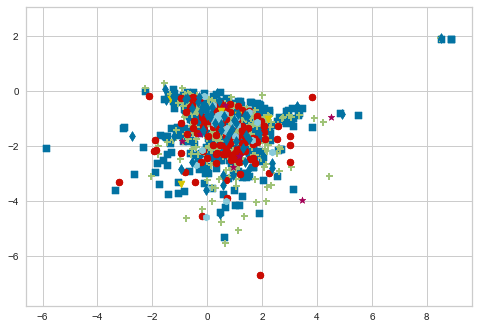

In [216]:
from yellowbrick.contrib import ScatterVisualizer
visualizer = ScatterVisualizer(x="x", y="y")
visualizer.fit(encoded_imgs[:, :2], y_train[:, 1].astype(int))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

TSNEVisualizer(alpha=0.7,
               ax=<matplotlib.axes._subplots.AxesSubplot object at 0x1593606d0>,
               classes=None, colormap=None, colors=None, decompose=None,
               decompose_by=None, labels=None, random_state=None)

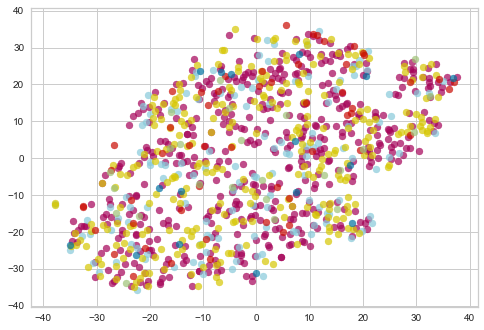

In [148]:
from yellowbrick.text import TSNEVisualizer
tsne = TSNEVisualizer(decompose=None)
tsne.fit(encoded_imgs, y_train[:, 1].astype(int))

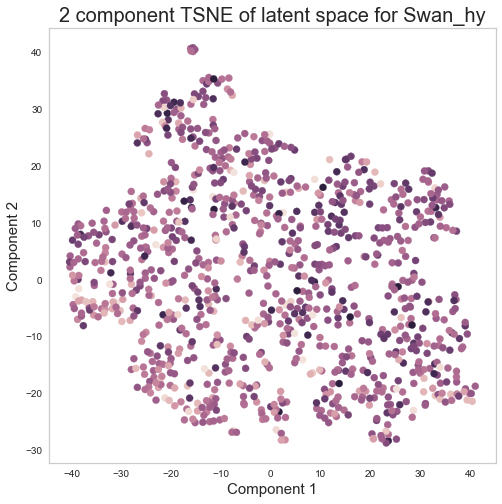

In [220]:
from sklearn.manifold import TSNE
import random
import seaborn as sns

X_r = TSNE(n_components=2).fit_transform(encoded_imgs)
y = (y_train[:, 2] + 3.0)/6.0

df = pd.DataFrame(data = X_r,
                          columns = ['component 1' ,
                                    'component 2'])

labels = pd.DataFrame(y)

finalDf = pd.concat([df, labels] , axis=1)

fig = plt.figure(figsize = (8,8))

ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Component 1', fontsize = 15)
ax.set_ylabel('Component 2', fontsize = 15)
ax.set_title('2 component TSNE of latent space for Swan_hy', fontsize = 20)


cmap = sns.cubehelix_palette(light=.9, as_cmap=True)
ax.scatter(df['component 1'], df['component 2'], c=y, s=50, cmap=cmap)
#ax.legend(target_val)
ax.grid()

plt.savefig('plot_tnse_swan_hy.png')
plt.show()

In [257]:
from sklearn import svm
svr= svm.SVR()
parameters = {'kernel' : ( 'rbf' , 'sigmoid' ), 'C':[0.1, 1,10,100], 'gamma':['auto']}
clf = GridSearchCV(svr, parameters ,cv =5, scoring='neg_mean_squared_error')
x = np.hstack((encoded_imgs, y_train[:,0].reshape((-1, 1))))
clf.fit(x , y_train[:,2])

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': ['auto'],
                         'kernel': ('rbf', 'sigmoid')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [258]:
clf.best_score_

-1.3698235908769532

In [259]:
sklearn.metrics.mean_squared_error(y_test[:,2] , clf.predict(np.hstack((encoder.predict(x_test)[2], y_test[:,0].reshape((-1, 1))))))

1.1982777457190006

In [260]:
y = np.zeros(len(y_test))
y = y + np.mean(y_train[:,2])
sklearn.metrics.mean_squared_error(y, y_test[:,2])

1.2810226064671015